# Forecasting Blood Donation

The dataset used in this project originates from Malaysia's open data portal, data.gov.my, which provides publicly accessible records of blood donation transactions across various Malaysian states. This dataset includes daily records of the number of blood donations, categorized by state and blood type.


We selected this dataset due to the lack of publicly available government data on blood donations in Indonesia. As of now, there is no centralized or open-access platform provided by the Indonesian government that contains similar structured data on blood donation transactions.

By using this dataset, we can build and evaluate deep learning models that predict blood donation trends, detect anomalies in donation volumes, or inform donor outreach strategies. These models can later be adapted to Indonesian data once such information becomes accessible.

Resources : https://data.gov.my/data-catalogue/blood_donations_state?state=johor&blood_type=all&visual=table

**Importing Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

**Data Understanding**

In [3]:
file_path = '/content/drive/MyDrive/Prediction_City/blood_donations_state.csv'
df = pd.read_csv(file_path)


The previous code is used in Google Colab to load a CSV file from your Google Drive into a Pandas DataFrame.

In [4]:
df.head()

,date,state,blood_type,donations
0,2006-01-01,Johor,all,87
1,2006-01-02,Johor,all,15
2,2006-01-03,Johor,all,8
3,2006-01-04,Johor,all,33
4,2006-01-05,Johor,all,20


The previous code is used to display the first 5 rows of the DataFrame.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460915 entries, 0 to 460914
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        460915 non-null  object
 1   state       460915 non-null  object
 2   blood_type  460915 non-null  object
 3   donations   460915 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 14.1+ MB


The dataset contains a total of **460,915 entries** and includes four columns: `date`, `state`, `blood_type`, and `donations`. Each row represents a record of blood donation transactions in Malaysia, specifying the date of donation, the state where it occurred, the blood type involved, and the number of donations made. The `donations` column is stored as an integer, while the other three columns are stored as object data types. Notably, there are no missing values in any of the columns, indicating that the dataset is complete and ready for analysis.

<ipython-input-6-146dc39240f7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_donations.index, y=state_donations.values, palette='viridis')


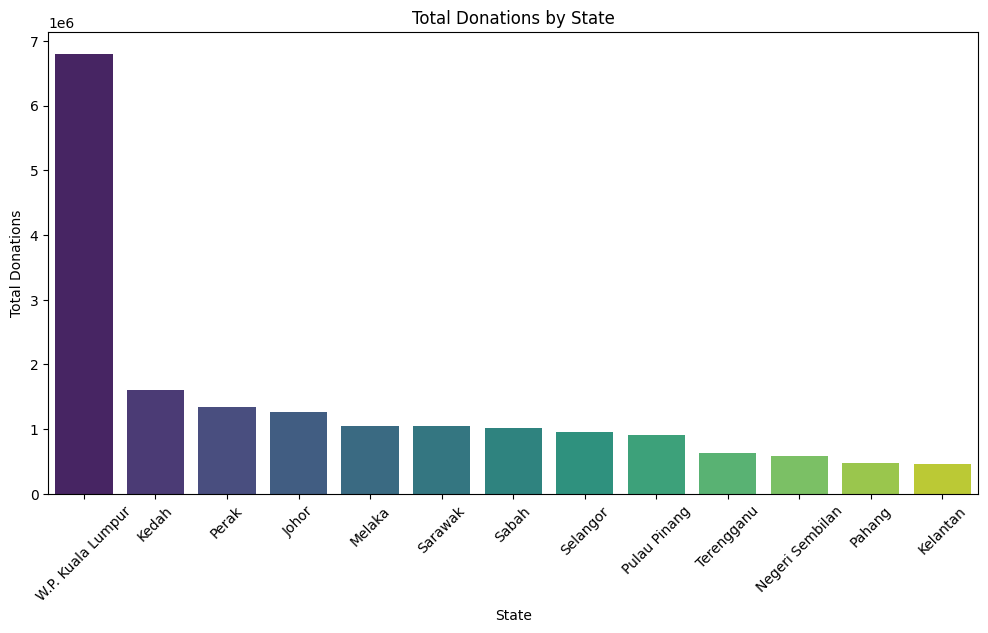

In [6]:
state_donations = df.groupby('state')['donations'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=state_donations.index, y=state_donations.values, palette='viridis')
plt.title('Total Donations by State')
plt.xlabel('State')
plt.ylabel('Total Donations')
plt.xticks(rotation=45)
plt.show()

<ipython-input-7-1ac41a8a779f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bloodtype_donations.index, y=bloodtype_donations.values, palette='magma')


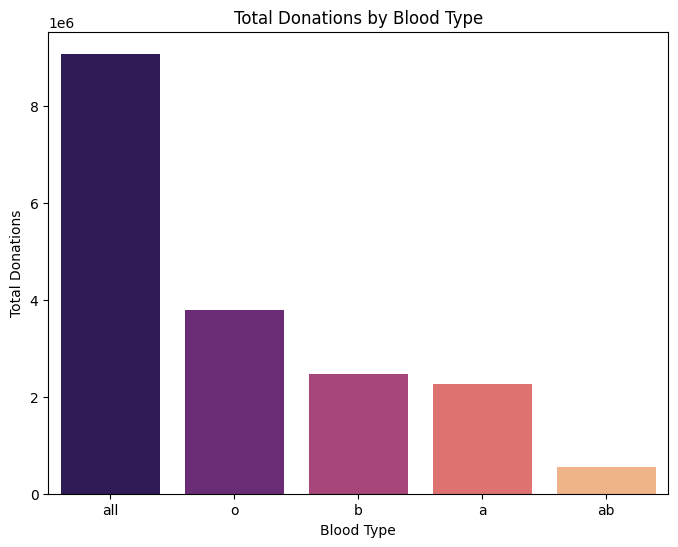

In [7]:
bloodtype_donations = df.groupby('blood_type')['donations'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=bloodtype_donations.index, y=bloodtype_donations.values, palette='magma')
plt.title('Total Donations by Blood Type')
plt.xlabel('Blood Type')
plt.ylabel('Total Donations')
plt.show()

In [8]:
states = df['state'].unique()
blood_types =  df['blood_type'].unique()

print(states)
print(blood_types)

['Johor' 'Kedah' 'Kelantan' 'Melaka' 'Negeri Sembilan' 'Pahang' 'Perak'
 'Pulau Pinang' 'Sabah' 'Sarawak' 'Selangor' 'Terengganu'
 'W.P. Kuala Lumpur']
['all' 'a' 'b' 'o' 'ab']


**Pre-processing Data**

In [9]:
df['date'] = pd.to_datetime(df['date'])

converts the 'date' column in your DataFrame df from strings (text) into Pandas datetime objects

In [10]:
df = df.sort_values(['state', 'blood_type', 'date'])

sorting the rows of the dataframe df based on multiple columns

In [11]:
df_kuala_lumpur = df[df['state'] == 'W.P. Kuala Lumpur'].copy()

In [12]:
df_kuala_lumpur.head()

,date,state,blood_type,donations
177275,2006-01-01,W.P. Kuala Lumpur,a,63
177276,2006-01-02,W.P. Kuala Lumpur,a,23
177277,2006-01-03,W.P. Kuala Lumpur,a,13
177278,2006-01-04,W.P. Kuala Lumpur,a,71
177279,2006-01-05,W.P. Kuala Lumpur,a,69


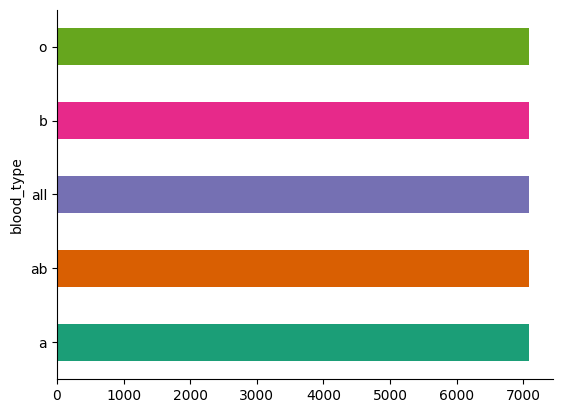

In [13]:
df_kuala_lumpur.groupby('blood_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

By selecting data from a single state, we ensure that the data is more consistent in terms of local factors such as healthcare infrastructure, demographics, and regional policies. This reduces noise and variability caused by differences across states, which can improve the accuracy and reliability of the model.

Kuala Lumpur and Jakarta share many similarities as major metropolitan capitals in their respective countries (Malaysia and Indonesia). Both cities have diverse and dense urban populations with similar challenges in healthcare access and public health management.

By focusing on Kuala Lumpur’s data, insights and modeling techniques can be more relevant or transferable when later analyzing Jakarta’s data or similar urban centers. The localized model for Kuala Lumpur serves as a useful benchmark or pilot before expanding the approach to Jakarta, where analogous urban dynamics exist.

In [14]:
df_kuala_lumpur = df_kuala_lumpur.drop(columns=['state'])

to make it more simple, we delete the state column as we only using Kuala Lumpur

In [15]:
df_kuala_lumpur['day_name'] = df_kuala_lumpur['date'].dt.day_name()

extract the day of the week from a datetime column

In [16]:
df_kuala_lumpur['is_weekend'] = df_kuala_lumpur['date'].dt.dayofweek >= 5
df_kuala_lumpur['is_month_start'] = df_kuala_lumpur['date'].dt.is_month_start
df_kuala_lumpur['is_month_end'] = df_kuala_lumpur['date'].dt.is_month_end

adding features to make it clearer

In [17]:
fix_dataset = df_kuala_lumpur[df_kuala_lumpur['blood_type'] == 'all']

For simplicity, we only analyze based on total bag of donation

In [18]:
fix_dataset = fix_dataset.drop(columns=['blood_type'])

Since we only use the total donation, we can drop the blood_type column

In [19]:
fix_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7091 entries, 85092 to 92182
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            7091 non-null   datetime64[ns]
 1   donations       7091 non-null   int64         
 2   day_name        7091 non-null   object        
 3   is_weekend      7091 non-null   bool          
 4   is_month_start  7091 non-null   bool          
 5   is_month_end    7091 non-null   bool          
dtypes: bool(3), datetime64[ns](1), int64(1), object(1)
memory usage: 242.4+ KB


**LSTM MODELING**

In [20]:
df_encoding = pd.get_dummies(fix_dataset, columns=['day_name'])

One-hot encode day_name


In [21]:
features = [col for col in df_encoding.columns if col not in ['date', 'donations']]
target = 'donations'

Feature columns

In [22]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_encoding[features])

Scale features

In [23]:
y = df_encoding[target].values.reshape(-1, 1)
y_scaled = MinMaxScaler().fit_transform(y)

 Scale the target separately

In [24]:
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)


Create sequences for LSTM (e.g., 10 days of history to predict next day)

In [25]:
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

Split into train and test (80% train and 20% test)

In [26]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(1)
])

We use the code snippet with the Sequential model and an explicit Input layer to clearly define the shape of the input data the model expects. The Input(shape=(X_train.shape[1], X_train.shape[2])) specifies that each sample consists of a sequence of time steps (for example, 10 days) with multiple features at each step. This makes the model architecture clear and avoids warnings related to input shape specifications. The LSTM layer with 64 units processes these sequences to learn temporal dependencies and patterns within the time series data by using the tanh activation which is effective for controlling the cell state updates. Following the LSTM, a fully connected Dense layer with 32 neurons and ReLU activation adds non-linearity, allowing the model to learn more complex relationships from the LSTM’s output. Finally, the last Dense layer outputs a single continuous value, which in this case represents the predicted number of donations for the next day. This layered structure allows the model to effectively capture sequential patterns and produce accurate regression predictions.


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,313 (83.25 KB)

 Trainable params: 21,313 (83.25 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [29]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0107 - mae: 0.0790 - val_loss: 0.0078 - val_mae: 0.0678
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0076 - mae: 0.0652 - val_loss: 0.0077 - val_mae: 0.0686
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0073 - mae: 0.0655 - val_loss: 0.0078 - val_mae: 0.0705
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0673 - val_loss: 0.0074 - val_mae: 0.0668
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0645 - val_loss: 0.0081 - val_mae: 0.0693
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0660 - val_loss: 0.0074 - val_mae: 0.0641
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0658 - val_loss: 0.0075 - val_mae: 0.0669
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0644 - val_loss: 0.0074 - val_mae: 0.0661
Epoch 9/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step -

In [30]:
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f} - MAE: {mae:.4f}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - mae: 0.0593
Test Loss: 0.0069 - MAE: 0.0619


In [31]:
predictions = model.predict(X_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


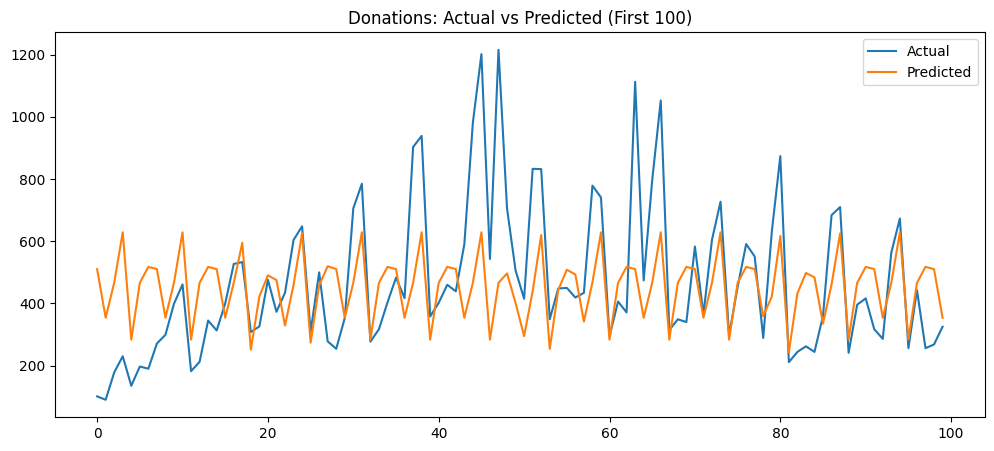

In [32]:
y_test_inv = MinMaxScaler().fit(y).inverse_transform(y_test)
predictions_inv = MinMaxScaler().fit(y).inverse_transform(predictions)

plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:100], label='Actual')
plt.plot(predictions_inv[:100], label='Predicted')
plt.title('Donations: Actual vs Predicted (First 100)')
plt.legend()
plt.show()

This graph plots the first 100 actual donation values (y_test_inv) against the model’s predicted donation values (predictions_inv). Both series have been transformed back to their original scale using inverse MinMax scaling so the numbers represent real donation counts. Any gaps or deviations highlight where the model’s predictions differ from reality, helping identify areas for improvement or anomalies in the data.

**Saving The Model**

In [34]:
df_encoding.to_csv('final_dataset.csv', index=False)

In [36]:
model.save('model_lstm.h5')